<center><img src="https://mlflow.org/docs/0.4.1/_static/MLflow-logo-final-black.png" width="300" align="center" /><center>
 <center><h1><i>“platform for the machine learning lifecycle”</i></h1><center>
MLFlow es una plataforma open source que permite administrar el ciclo de vida de ML, incluyendo la experimentación, reproducibilidad y deploy de modelos, además de brindar la posibilidad de comparar la performance de los modelos obtenidos a lo largo del proyecto. Es posible utilizarla con múltiples lenguajes, tanto de manera local como en la nube. 

# Ejemplo de implementación de Pyfunc
Pyfunc define un formato de sistema de archivos genérico para los modelos Python. Proporciona utilidades para guardar y cargar modelos desde y hacia este formato.<br>
Es autónomo en el sentido de que incluye toda la información necesaria para cargar y usar un modelo. Las dependencias se almacenan directamente con el modelo o se hace referencia a través del entorno Conda. <br>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import mlflow
import mlflow.pyfunc
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Miniconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


#### Definir la Clase del algoritmo que vamos a usar
Requisitos minimos: <br>
* Función init: necesaria para la creación de la clase
* Función load_context: Dependencias del modelo usado
* Funcion predict: Método necesario para que, una vez guardado, el modelo se pueda usar para predecir


In [2]:
class HOLT(mlflow.pyfunc.PythonModel):

    def __init__(self, model):
        self.model = model
        super(HOLT, self).__init__()


    def load_context(self, context):
        from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
        return

    def predict(self, context, model_input):
        future = self.model.forecast(len(model_input))
        return future

### Desarrollo de un modelo de Series Temporales

### Leer y preparar el dataset

In [3]:
#Importing data
df = pd.read_csv('Train_SU63ISt.csv')
#Printing head
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()

#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('Train_SU63ISt.csv', nrows = 11856)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:10392] 
test=df[10392:]

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

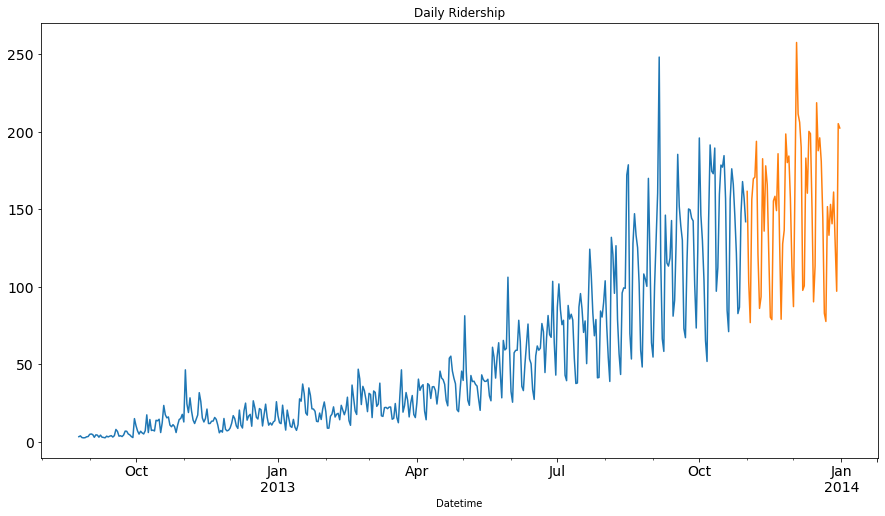

In [5]:
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

### Entrenamos y guardamos el modelo

In [6]:
mlflow.set_experiment('series_temporales')

with mlflow.start_run():
    y_hat_avg = test.copy()
    fit1 = ExponentialSmoothing( \
                        np.asarray(train['Count']) ,
                        seasonal_periods=7 ,
                        trend='add', seasonal='add',).fit()
    mlflow.pyfunc.log_model("model", python_model=HOLT(fit1))

#### Probamos el modelo entrenado(no guardado en mlflow)

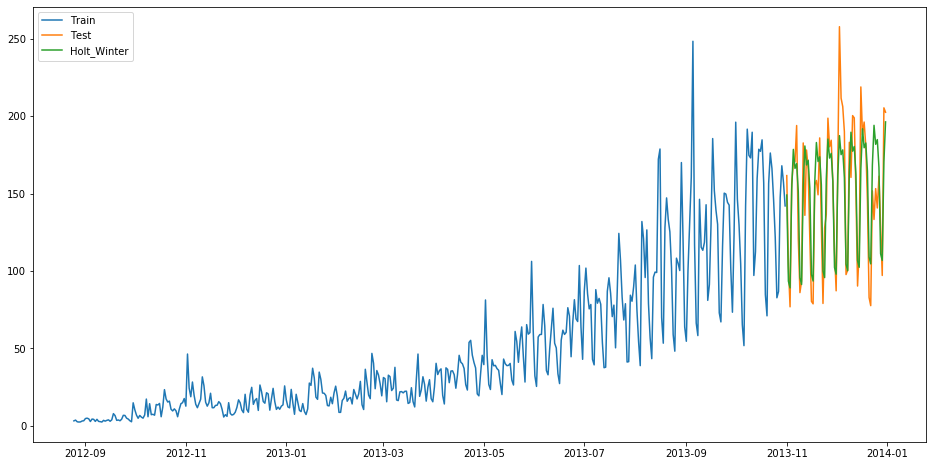

In [7]:
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
#y_hat_avg['Holt_Winter']
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

#### Vemos el experimento guardado, y accedemos al modelo

In [8]:
mlflow.tracking.MlflowClient().list_experiments()

[<Experiment: artifact_location='file:///C:/Users/MelinaSolovey/OneDrive%20-%20Pi%20Data%20Strategy%20%26%20Consulting/Data%20Science/Momentos%20Nerd/WiDS/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/MelinaSolovey/OneDrive%20-%20Pi%20Data%20Strategy%20%26%20Consulting/Data%20Science/Momentos%20Nerd/WiDS/mlruns/1', experiment_id='1', lifecycle_stage='active', name='iris', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/MelinaSolovey/OneDrive%20-%20Pi%20Data%20Strategy%20%26%20Consulting/Data%20Science/Momentos%20Nerd/WiDS/mlruns/2', experiment_id='2', lifecycle_stage='active', name='test1', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/MelinaSolovey/OneDrive%20-%20Pi%20Data%20Strategy%20%26%20Consulting/Data%20Science/Momentos%20Nerd/WiDS/mlruns/3', experiment_id='3', lifecycle_stage='active', name='series_temporales', tags={}>]

In [9]:
mlflow.search_runs(experiment_ids="3")

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.aic,metrics.dickey-fuller-test,metrics.bic,metrics.número de observaciones,params.seasonal,params.no seasonal,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.parentRunId
0,1561482dfc7a4a219718781a799a4c07,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-30 17:29:29.419000+00:00,2020-01-30 17:29:29.970000+00:00,NaN,NaN,NaN,NaN,None,None,LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,None
1,d54cd3c91da84fe8a52764eab6a7f31a,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-29 19:43:06.130000+00:00,2020-01-29 19:43:06.487000+00:00,NaN,NaN,NaN,NaN,None,None,LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,None
2,7e442dc35da24d64b8425acb401c7c2b,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-29 19:41:51.387000+00:00,2020-01-29 19:41:51.762000+00:00,NaN,NaN,NaN,NaN,None,None,LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,None
3,66830f304cc745f9aad93349f18d524a,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-29 19:11:28.468000+00:00,2020-01-29 19:11:28.885000+00:00,NaN,NaN,NaN,NaN,None,None,LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,None
4,500c2cdaf7b046a3b910b66cc7d18b66,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-29 18:53:13.088000+00:00,2020-01-29 18:53:13.575000+00:00,NaN,NaN,NaN,NaN,None,None,LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,None
5,bfd5c5927e5e4075af5972ebbeded048,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-29 18:25:14.759000+00:00,2020-01-29 18:25:15.716000+00:00,223.109781,1.873204e-08,223.701454,36.0,"(0, 1, 1, 12)","(0, 1, 1)",LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,None
6,cd63e7facbc844198df35cc8c898377b,3,FINISHED,file:///C:/Users/MelinaSolovey/OneDrive%20-%20...,2020-01-29 18:21:46.381000+00:00,2020-01-29 18:21:47.091000+00:00,223.109781,1.873204e-08,223.701454,36.0,"(0, 1, 1, 12)","(0, 1, 1)",LOCAL,C:\ProgramData\Miniconda3\lib\site-packages\ip...,MelinaSolovey,a4e72c7c712c445f8719f732219217a7


In [10]:
model_uri = mlflow.search_runs(experiment_ids="3").artifact_uri[0]
model_uri

'file:///C:/Users/MelinaSolovey/OneDrive%20-%20Pi%20Data%20Strategy%20%26%20Consulting/Data%20Science/Momentos%20Nerd/WiDS/mlruns/3/1561482dfc7a4a219718781a799a4c07/artifacts'

In [11]:
my_model = mlflow.pyfunc.load_model(model_uri+'/model')

#### Predicción

In [12]:
my_model.predict(test)

array([149.00920255,  93.35934296,  89.04284555, 152.66667328,
       178.49556363, 166.22972228, 169.28954182, 151.22980627,
        95.57994668,  91.26344927, 154.887277  , 180.71616734,
       168.45032599, 171.51014553, 153.45040998,  97.80055039,
        93.48405298, 157.10788072, 182.93677106, 170.67092971,
       173.73074925, 155.6710137 , 100.02115411,  95.7046567 ,
       159.32848443, 185.15737477, 172.89153343, 175.95135296,
       157.89161741, 102.24175783,  97.92526042, 161.54908815,
       187.37797849, 175.11213714, 178.17195668, 160.11222113,
       104.46236154, 100.14586413, 163.76969186, 189.59858221,
       177.33274086, 180.3925604 , 162.33282485, 106.68296526,
       102.36646785, 165.99029558, 191.81918592, 179.55334457,
       182.61316411, 164.55342856, 108.90356897, 104.58707156,
       168.2108993 , 194.03978964, 181.77394829, 184.83376783,
       166.77403228, 111.12417269, 106.80767528, 170.43150301,
       196.26039335])

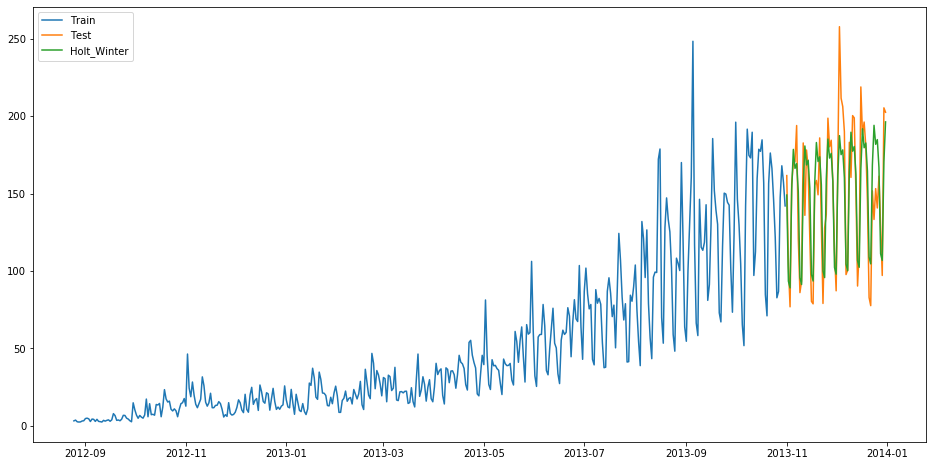

In [13]:
y_hat_avg['Holt_Winter'] = my_model.predict(test)
#y_hat_avg['Holt_Winter']
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()